# Comparison of the NCSB algorithm to older algortihms for NBA complementation

This Notebook gathers number of states and transitions of the produced automata, creates the tables and data used for the figures used in the paper. Thois notebook assumes that the simplified automata are already created. They can be created using `Makefile` generated by the [Makefile Notebook](generate_Makefiles.ipynb)(the simplifiacation part).

In [1]:
%run Evaluation-lib.ipynb
%matplotlib inline
import pandas as pd
import spot
import os
from ipywidgets import FloatProgress, IntProgress
from IPython.display import display

## Collecting size statistics
The following fuctions and commands serve to collect the numbers of states and transitions for the original complements returned by `Ultimate` and `GOAL` with various algorithms, and saves them to a file `stats.csv`.

In [2]:
def get_stats(aut):
    if not is_computed(aut):
        return None,None
    s = spot.stats_reachable(spot.automaton(aut)).states
    t = spot.sub_stats_reachable(spot.automaton(aut)).transitions
    return s,t

In [3]:
def get_all_stats():
    
    entries = dict()
    f = FloatProgress(min=1, max=len(get_cases()),description='Overall')
    g = FloatProgress(min=1, max=24,color='green',description='One case')
    display(f,g)
    for cs in get_cases():
        f.value += 1
        g.max=2*(len(get_complements(cs)))
        g.value = g.min
        for c in get_complements(cs):
            st,tr = get_stats(c);g.value += 1
            simp_st,simp_tr = get_stats(get_simplified_path(c,'high'))
            entries[c]=dict(case=cs,
                        alg=get_algorithm_name(c),
                        states=st,transitions=tr,
                        states_simp=simp_st,
                        transitions_simp=simp_tr)
            g.value += 1
    return pd.DataFrame(entries).T

In [4]:
data = get_all_stats()
data.to_csv('stats.csv',index_label='file')

## Tables, figures, etc.

In [5]:
def cut_index(df,values=None,level=0):
    '''Restrict the data in given Dataframe `df` by
    dropping rows with index not in `values`.
    
    Parameters:
    -----------
    df: Dataframe
    values: allowed values of the index, default None 
        (whichs results in an empty df)
    level: level on which we restrict, default 0
    '''
    return df.select(lambda x: x[level] in values)

The basic setting for our analysis follows: 
 * `tools` specifies which tools we compare,
 * `cols` specifies which columns we use in our evaluation,
 * `simp_cols` specifies the columns with values for simplified automata,
 * `ind` specifies the columns used as index. We identify the complements by a pair $(case,algorithm)$.

In [6]:
tools=['GoalRamsey',
'GoalRank',
"GoalSafraPiterman",
'GoalSlice',
'UltimateBS']
cols=['states','transitions']
simp_cols=['states_simp','transitions_simp']
ind=['case','alg']

read the data from the csv file

In [7]:
df = pd.DataFrame.from_csv('stats.csv',index_col=ind)[cols+simp_cols]
data = cut_index(df,tools,1)

### Table 2
We first identify the *easy* and *difficult* tasks:
 * `easy` is a task where all complementations gave a result
 * `difficult` is a task which is not `easy`

In [8]:
easy = data[cols].unstack().dropna().stack()
difficult = data[cols][~data.index.isin(easy.index)].dropna()

Now create the `table2` by merging a cummulatve number of `states`,`transitions` for easy automata and a number of states for each difficult automaton.

In [9]:
table2 = easy.groupby(level='alg').sum().join\
    (difficult['states'].unstack(level=0))
table2.columns = cols + list(range(1,len(difficult.unstack(level=1))+1))
display(table2)

,states,transitions,1,2,3,4,5,6
alg,,,,,,,,
GoalRamsey,16909,848969,NaN,NaN,NaN,NaN,NaN,NaN
GoalRank,2703,21095,NaN,NaN,1022,7460,8245,NaN
GoalSafraPiterman,1841,24964,NaN,NaN,172,346,385,3527
GoalSlice,1392,14783,66368,NaN,184,421,475,9596
UltimateBS,950,8003,20711,84567,108,343,401,5449


In [10]:
print(table2.to_latex(index_names=False,na_rep='--'),file=open('tab_no_simp.tex','w'))

### Scatter plot for easy automata
For each easy automaton, the smallest complement produced by any _old_ algorithm is picked and compared to the one produced by NCSB algotihm.

In [11]:
others = easy.drop('UltimateBS',level=1).groupby(level=0).min()
NCSB = cut_index(easy,['UltimateBS'],1).reset_index(level='alg',)[cols]
data_for_scatter = NCSB.join(others,rsuffix='_other',how='inner')
data_for_scatter.to_csv('our2min_comparison.csv')

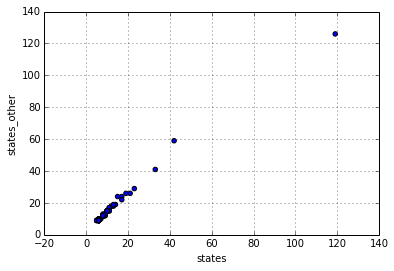

In [12]:
data_for_scatter.plot(x='states',y='states_other',kind='scatter')

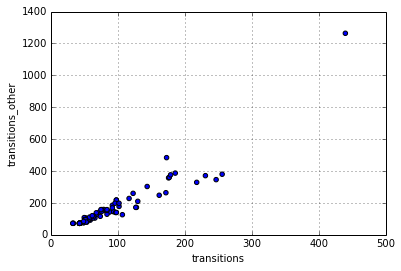

In [13]:
data_for_scatter.plot(x='transitions',y='transitions_other',kind='scatter')

### Verify that NCSB produced an automaton with a minimum number of states for all `easy` automata

In [14]:
mins=data.groupby(level=0).min()
display((easy.states.unstack(level=0) == mins.states).T.sum())

alg
GoalRamsey            0
GoalRank              0
GoalSafraPiterman     0
GoalSlice             0
UltimateBS           91
dtype: int64

### Table 3
Table 3 shows figures for cases, where simplification of all complements finished within timeout, we call them `simplified_all`. We assume here that the simplified automata are in directory `simplified`. They can be created using `Makefile` generated by the [Makefile Notebook](generate_Makefiles.ipynb).

In [15]:
all_simplified = data.unstack().dropna().stack()
print('Number of `simplified_all` cases: {}'.\
 format(len(all_simplified.groupby(level=0))))

Number of `simplified_all` cases: 75


There are three kinds of figures in Table 3:
1. `summary` -- cummulative numbers of states and transitions of complements before and after simplification,
2. `min_count` -- the number of cases when the simplified automaton was the minimal among the simplified complements,
3. `failures` -- number of failures, i.e., in how many cases the algorithm failed to produce an complement within T/O, and in how many cases `autfilt` failed to simplify the complement within T/O because of its size.

We create each part independently.

In [16]:
summary = all_simplified.groupby(level=1).sum()
min_nums = pd.DataFrame((all_simplified.
    states_simp.unstack(level=0) == mins.states_simp)\
    .T.sum(),columns=['min'])### Set the name of the column
failures = 97-data[['states','states_simp']].groupby(level=1).count()\
    .rename_axis({'states' : 'compl.','states_simp':'simp.'},axis=1)

Merge the three kinds of information and partition the header into three parts:
1. `no simplifications` (cummulative numbers)
2. `with simplifications` (cummulative numbers + min)
3. `failures`

In [17]:
table3 = summary.join([min_nums,failures])
table3 = table3.T.set_index([
    ['no simplifications']*2+
    ['with simplifications']*3+
    ['failure']*2],append=True).swaplevel(1,0).T
display(table3)

no simplifications               with simplifications  \
                               states  transitions           states_simp   
alg                                                                        
GoalRamsey                       6386       172351                  5223   
GoalRank                         1437        11677                   899   
GoalSafraPiterman                1300        15491                  1083   
GoalSlice                         892         8921                   785   
UltimateBS                        598         4922                   514   

                                          failure         
                   transitions_simp  min   compl.  simp.  
alg                                                       
GoalRamsey                    90548    0        6     22  
GoalRank                       7657    4        3     14  
GoalSafraPiterman              9589    0        2     11  
GoalSlice                      6789    4        1     13  
UltimateBS                     4460   73        0     10  

[5 rows x 7 columns]

In [18]:
print(table3.to_latex(index_names=False,na_rep='--'),file=open('tab_simp.tex','w'))